# Two-dimensional cone sampling visualization

(First draft version).

## Implementation

(Expand in order to read the code).

In [1]:
!pip install botorch

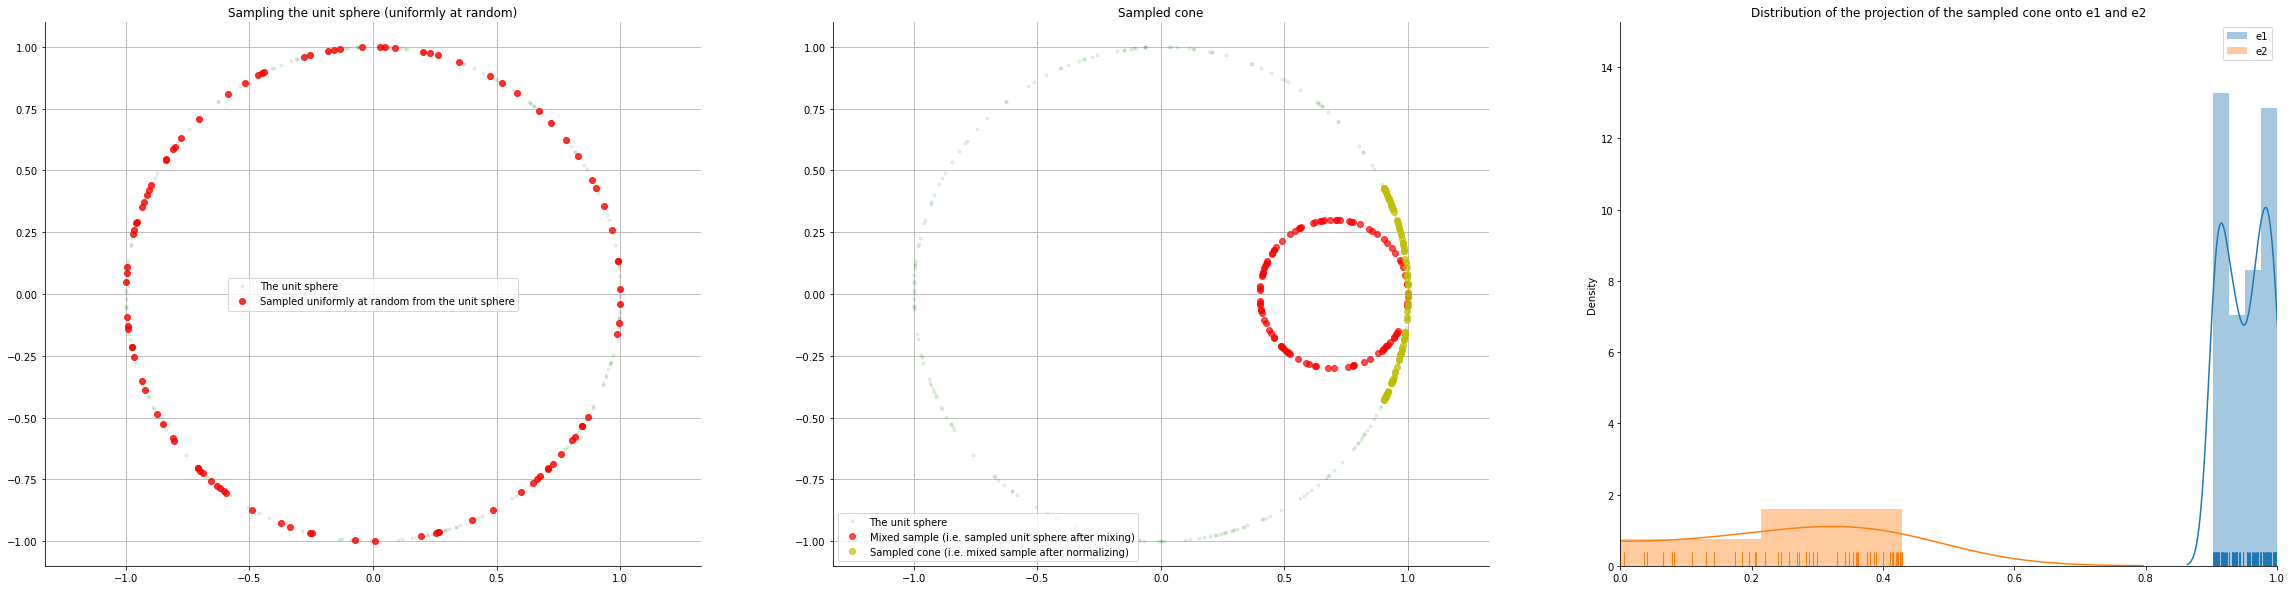

In [21]:
import torch
import matplotlib.pyplot as plt
from botorch.utils.sampling import *
from ipywidgets import interact, fixed
import seaborn as sns
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


# Copied from BoTorch because Google Colab has only an old version of BoTorch
# https://raw.githubusercontent.com/pytorch/botorch/master/botorch/utils/sampling.py
def sample_hypersphere(
    d: int,
    n: int = 1,
    qmc: bool = False,
    seed: Optional[int] = None,
    device: Optional[torch.device] = None,
    dtype: Optional[torch.dtype] = None,
) -> Tensor:
    r"""Sample uniformly from a unit d-sphere.
    Args:
        d: The dimension of the hypersphere.
        n: The number of samples to return.
        qmc: If True, use QMC Sobol sampling (instead of i.i.d. uniform).
        seed: If provided, use as a seed for the RNG.
        device: The torch device.
        dtype:  The torch dtype.
    Returns:
        An  `n x d` tensor of uniform samples from from the d-hypersphere.
    Example:
        >>> sample_hypersphere(d=5, n=10)
    """
    dtype = torch.float if dtype is None else dtype
    if d == 1:
        rnd = torch.randint(0, 2, (n, 1), device=device, dtype=dtype)
        return 2 * rnd - 1
    if qmc:
        rnd = draw_sobol_normal_samples(d=d, n=n, device=device, dtype=dtype, seed=seed)
    else:
        with manual_seed(seed=seed):
            rnd = torch.randn(n, d, dtype=dtype)
    samples = rnd / torch.norm(rnd, dim=-1, keepdim=True)
    if device is not None:
        samples = samples.to(device)
    return samples

def _sample_uniformly_at_random_from_the_unit_sphere(dim, num_of_samples):
    return sample_hypersphere(d=dim, n=num_of_samples)

def _display_2d(ax, title, *datasets2d_kwargs):
    # plot given inputs
    for dataset2d_kwargs in datasets2d_kwargs:
      data2d = dataset2d_kwargs['data']
      fmt = dataset2d_kwargs['fmt']
      alpha = dataset2d_kwargs['alpha']
      label = dataset2d_kwargs['label']
      ax.plot(data2d[:, 0], data2d[:, 1], fmt, label=label, alpha=alpha)
    ax.set_title(title)
    ax.axis('equal')
    ax.grid(True)
    ax.legend()

# def _display_3d(data3d):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(data3d[:, 0], data3d[:, 1], data3d[:, 2])
#     ax.set_xlabel('X Label')
#     ax.set_ylabel('Y Label')
#     ax.set_zlabel('Z Label')
#     plt.show()

def _get_ei(i, dim, num_of_repeats):
    ei = torch.eye(dim)[i - 1]
    eis = ei.repeat(1, num_of_repeats).view(num_of_repeats, dim)
    return eis

def _mix(sampled_unit_sphere, mixing_param):
    num_of_samples = sampled_unit_sphere.shape[0]
    dim = sampled_unit_sphere.shape[1]
    # e1 = torch.eye(1, dim)
    # e1s = e1.repeat(1, num_of_samples).view(num_of_samples, dim)
    e1s = _get_ei(i=1, dim=dim, num_of_repeats=num_of_samples)
    return (1 - mixing_param) * e1s + mixing_param * sampled_unit_sphere

def _normalize(data):
    return data / torch.norm(data, dim=1, keepdim=True)

def _dot_product_row_wise(A: Tensor, B: Tensor) -> Tensor:
  assert A.shape == B.shape
  num_of_rows = A.shape[0]
  num_of_columns = A.shape[1]
  res = torch.bmm(A.view(num_of_rows, 1, num_of_columns),
                  B.view(num_of_rows, num_of_columns, 1))
  return torch.flatten(res, start_dim=1)

def _project_onto_ei(data, i):
  eis = _get_ei(i=i, dim=data.shape[1], num_of_repeats=data.shape[0])
  return _dot_product_row_wise(data, eis)

def _display_distplots(ax, title, *datasets1d_kwargs) -> None:
    ax.set_title(title)
    ax.set_xlim(left=0, right=1)
    for dataset1d_kwargs in datasets1d_kwargs:
        data1d = dataset1d_kwargs['data']
        label = dataset1d_kwargs['label']
        sns.distplot(
            data1d,
            rug=True,
            label=label,
            ax=ax
        )
    plt.legend()
    sns.despine()

def sample_mix_and_display(mixing_param, dim=2, num_of_samples=100) -> None:
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(40,10))

    # Sample the unit sphere
    unit_sphere = _sample_uniformly_at_random_from_the_unit_sphere(
        dim=dim,
        num_of_samples=num_of_samples * dim
    )
    sampled_unit_sphere = _sample_uniformly_at_random_from_the_unit_sphere(
        dim=dim,
        num_of_samples=num_of_samples
    )
    # Plot the unit sphere and the sampled data
    unit_sphere_kwarg_to_plot = dict(
        data=unit_sphere,
        fmt='g.',
        alpha=.1,
        label='The unit sphere'
    )
    sampled_unit_sphere_kwarg_to_plot = dict(
        data=sampled_unit_sphere,
        fmt='ro',
        alpha=.8,
        label='Sampled uniformly at random from the unit sphere'
    )
    ax0_title = 'Sampling the unit sphere (uniformly at random)'
    ax0_data_to_plot = [
        unit_sphere_kwarg_to_plot,
        sampled_unit_sphere_kwarg_to_plot
    ]
    _display_2d(
        ax0,
        ax0_title,
        *ax0_data_to_plot
    )

    # Mix the sampled data, then normalize the result
    mixed_sample = _mix(
        sampled_unit_sphere=sampled_unit_sphere,
        mixing_param=mixing_param
    )
    sampled_cone = _normalize(mixed_sample)
    # Plot both (1) mixed and (2) mixed-then-normalized
    mixed_sample_kwarg_to_plot = dict(
        data=mixed_sample,
        fmt='ro',
        alpha=.7,
        label='Mixed sample (i.e. sampled unit sphere after mixing)'
    )
    sampled_cone_kwarg_to_plot = dict(
        data=sampled_cone,
        fmt='yo',
        alpha=.7,
        label='Sampled cone (i.e. mixed sample after normalizing)'
    )
    ax1_title = 'Sampled cone'
    ax1_data_to_plot = [
        unit_sphere_kwarg_to_plot,
        mixed_sample_kwarg_to_plot,
        sampled_cone_kwarg_to_plot
    ]
    _display_2d(
        ax1,
        ax1_title,
        *ax1_data_to_plot
    )

    # Plot the distribution of the projection of the sampled cone onto e1 and e2
    sampled_cone_projected_onto_e1 = _project_onto_ei(
        data=sampled_cone,
        i=1
    )
    sampled_cone_projected_onto_e2 = _project_onto_ei(
        data=sampled_cone,
        i=2
    )
    ax2_title = 'Distribution of the projection of the sampled cone onto e1 and e2'
    sampled_cone_projected_onto_e1_kwarg_to_plot = dict(
        data=sampled_cone_projected_onto_e1,
        label='e1'
    )
    sampled_cone_projected_onto_e2_kwarg_to_plot = dict(
        data=sampled_cone_projected_onto_e2,
        label='e2'
    )
    ax2_data_to_plot = [
        sampled_cone_projected_onto_e1_kwarg_to_plot,
        sampled_cone_projected_onto_e2_kwarg_to_plot
    ]
    _display_distplots(
        ax2,
        ax2_title,
        *ax2_data_to_plot
    )


mixing_param = .3
sample_mix_and_display(mixing_param=mixing_param)

## How to use?

Slide the `mixing_parameter` between zero and one, while observing
1. the sampled cone (yellow dots on the middle figure); and 
2. the *distribution of the projection* of the sampled cone onto e1 and e2 (the figure on the right).



In [22]:
interact(sample_mix_and_display, mixing_param=(0 ,1 , 1e-5), dim=fixed(2), num_of_samples=fixed(300));

interactive(children=(FloatSlider(value=0.0, description='mixing_param', max=1.0, step=1e-05), Output()), _dom…